# ポアソンモデルを使用したBOCPDのデモ

このノートブックでは、カウントデータ（例：ウェブサイトアクセス数、エラー発生回数など）の変化点検出を実演します。

ポアソン-ガンマ共役モデルを使用し、予測分布は負の二項分布となります。

In [1]:
# notebooksディレクトリから実行する場合のパス設定
import sys
from pathlib import Path

# プロジェクトルートをパスに追加（notebooks/から親ディレクトリへ）
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import matplotlib.pyplot as plt
import numpy as np

from bocpd.detector import BOCPD
from bocpd.hazards import ConstantHazard
from bocpd.models import PoissonModel

# 日本語フォントの設定（オプション）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print(f"Project root: {project_root}")
print("Modules imported successfully!")

Project root: /Users/t106/github/bocpd
Modules imported successfully!


## 1. 変化点を持つポアソンデータの生成

3つの異なるレート（λ=3.0, 10.0, 5.0）を持つセグメントで構成されるデータを生成します。
変化点はt=100とt=200に設定します。

In [2]:
def generate_poisson_data_with_changepoints(
    n_points: int = 300,
    changepoints: list = [100, 200],
    rates: list = [3.0, 10.0, 5.0],
    seed: int = 42,
) -> np.ndarray:
    """変化点を持つポアソンカウントデータを生成"""
    np.random.seed(seed)
    
    # セグメントの境界を定義
    boundaries = [0] + changepoints + [n_points]
    data = np.zeros(n_points)
    
    # 各セグメントのデータを生成
    for i in range(len(boundaries) - 1):
        start = boundaries[i]
        end = boundaries[i + 1]
        rate = rates[i]
        data[start:end] = np.random.poisson(rate, size=end - start)
    
    return data


# データ生成
changepoints = [100, 200]
rates = [3.0, 10.0, 5.0]
data = generate_poisson_data_with_changepoints(
    n_points=300,
    changepoints=changepoints,
    rates=rates,
)

print(f"データポイント数: {len(data)}")
print(f"真の変化点: {changepoints}")
print(f"各セグメントのレート: {rates}")

データポイント数: 300
真の変化点: [100, 200]
各セグメントのレート: [3.0, 10.0, 5.0]


## 2. データの可視化

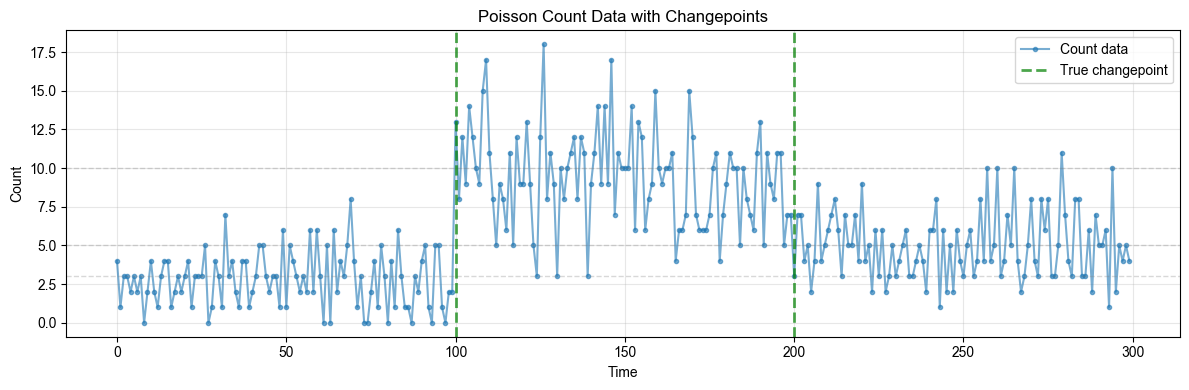

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(data, 'o-', markersize=3, alpha=0.6, label='Count data')
plt.axhline(y=3.0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
plt.axhline(y=10.0, color='gray', linestyle='--', alpha=0.3, linewidth=1)
plt.axhline(y=5.0, color='gray', linestyle='--', alpha=0.3, linewidth=1)

for cp in changepoints:
    plt.axvline(x=cp, color='green', linestyle='--', alpha=0.7, linewidth=2, label='True changepoint' if cp == changepoints[0] else '')

plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Poisson Count Data with Changepoints')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. PoissonModelの初期化

経験ベイズを使用して、最初の20データポイントからハイパーパラメータを推定します。

In [4]:
# 初期化用の少量のデータを使用
init_data = data[:20]

# PoissonModelを初期化
model = PoissonModel()
model.fit_empirical(init_data)

print(f"サンプル平均: {np.mean(init_data):.2f}")
print(f"モデル: {model}")
print(f"期待レート E[λ] = α/β = {model.alpha / model.beta:.2f}")

サンプル平均: 2.45
モデル: PoissonModel(alpha=2.0000, beta=0.8163)
期待レート E[λ] = α/β = 2.45


## 4. BOCPDの設定と実行

ハザード関数を設定し、オンライン変化点検知を実行します。

In [5]:
# ハザード関数を設定（期待ランレングス = 100）
hazard_rate = 1.0 / 100.0
hazard = ConstantHazard(hazard_rate)

print(f"ハザードレート: {hazard_rate}")
print(f"期待ランレングス: {1.0 / hazard_rate:.0f}")

# BOCPDを初期化してfitを実行
bocpd = BOCPD(model=model, hazard=hazard, max_run_length=200)
bocpd.fit(init_data)

print("\nBOCPD initialized successfully!")

ハザードレート: 0.01
期待ランレングス: 100

BOCPD initialized successfully!


In [6]:
# オンライン変化点検知を実行
print("変化点検知を実行中...")
results = []
detected_changepoints = []

for t, x in enumerate(data):
    result = bocpd.update(x)
    results.append(result)
    
    # 変化点検出（ランレングス=1で高確率）
    run_length = result["most_likely_run_length"]
    prob = result["run_length_dist"][run_length]
    
    if run_length == 1 and prob > 0.5:
        detected_changepoints.append(t)
        print(f"  時刻 {t}: 変化点検出（確率={prob:.3f}）")

print(f"\n検出された変化点: {detected_changepoints}")
print(f"真の変化点: {changepoints}")

変化点検知を実行中...
  時刻 0: 変化点検出（確率=0.990）
  時刻 100: 変化点検出（確率=0.617）

検出された変化点: [0, 100]
真の変化点: [100, 200]


## 5. 結果の可視化

3つのサブプロットで結果を表示：
1. カウントデータと変化点
2. ランレングス事後分布のヒートマップ
3. 最尤ランレングスと変化点確率

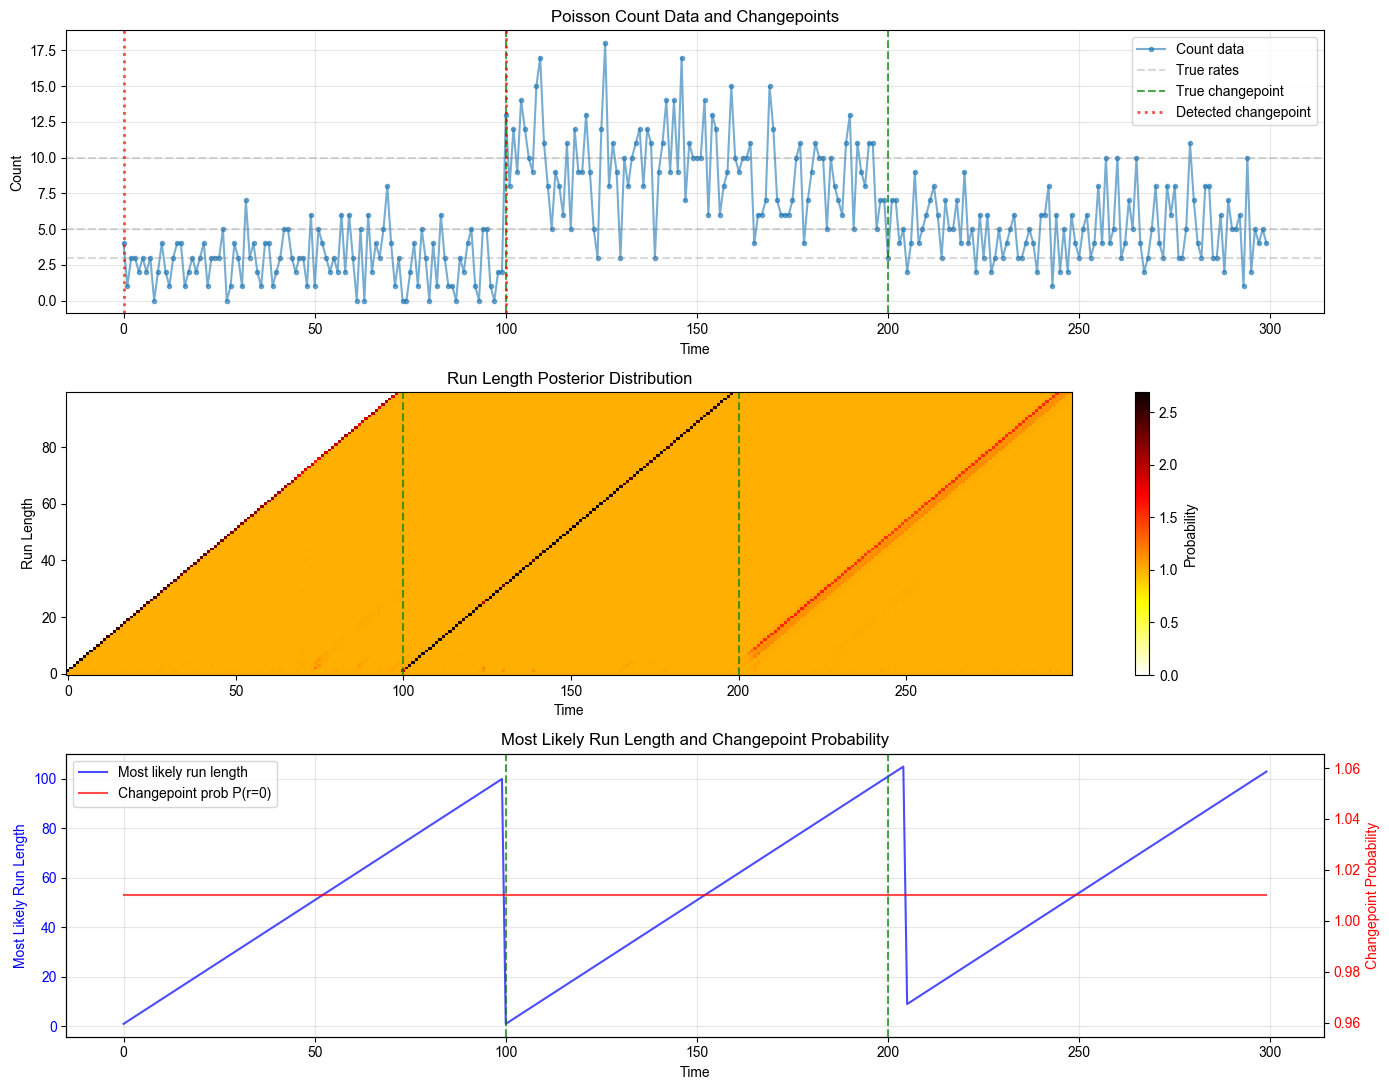

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(14, 11))

# サブプロット1: カウントデータ
ax1 = axes[0]
ax1.plot(data, "o-", markersize=3, alpha=0.6, label="Count data")
ax1.axhline(y=3.0, color="gray", linestyle="--", alpha=0.3, label="True rates")
ax1.axhline(y=10.0, color="gray", linestyle="--", alpha=0.3)
ax1.axhline(y=5.0, color="gray", linestyle="--", alpha=0.3)

for i, cp in enumerate(changepoints):
    ax1.axvline(x=cp, color="green", linestyle="--", alpha=0.7, 
                label="True changepoint" if i == 0 else "")

for i, cp in enumerate(detected_changepoints):
    ax1.axvline(x=cp, color="red", linestyle=":", alpha=0.7, linewidth=2,
                label="Detected changepoint" if i == 0 else "")

ax1.set_xlabel("Time")
ax1.set_ylabel("Count")
ax1.set_title("Poisson Count Data and Changepoints")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# サブプロット2: ランレングス分布（ヒートマップ）
ax2 = axes[1]
max_display_len = 100
run_length_matrix = np.zeros((max_display_len, len(results)))

for t, result in enumerate(results):
    dist = result["run_length_dist"]
    length = min(len(dist), max_display_len)
    run_length_matrix[:length, t] = np.exp(dist[:length])

im = ax2.imshow(
    run_length_matrix,
    aspect="auto",
    cmap="hot_r",
    interpolation="nearest",
    origin="lower",
)
ax2.set_xlabel("Time")
ax2.set_ylabel("Run Length")
ax2.set_title("Run Length Posterior Distribution")
plt.colorbar(im, ax=ax2, label="Probability")

for cp in changepoints:
    ax2.axvline(x=cp, color="green", linestyle="--", alpha=0.7)

# サブプロット3: 最尤ランレングスと変化点確率
ax3 = axes[2]
most_likely_run_lengths = [r["most_likely_run_length"] for r in results]
changepoint_probs = [np.exp(r["run_length_dist"][0]) for r in results]

ax3_twin = ax3.twinx()
ax3.plot(most_likely_run_lengths, "b-", alpha=0.7, label="Most likely run length")
ax3_twin.plot(changepoint_probs, "r-", alpha=0.7, label="Changepoint prob P(r=0)")

for cp in changepoints:
    ax3.axvline(x=cp, color="green", linestyle="--", alpha=0.7)

ax3.set_xlabel("Time")
ax3.set_ylabel("Most Likely Run Length", color="b")
ax3_twin.set_ylabel("Changepoint Probability", color="r")
ax3.set_title("Most Likely Run Length and Changepoint Probability")
ax3.tick_params(axis="y", labelcolor="b")
ax3_twin.tick_params(axis="y", labelcolor="r")
ax3.grid(True, alpha=0.3)

# 凡例を追加
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

## 6. 検出精度の評価

検出された変化点と真の変化点を比較します。

In [8]:
# 検出精度の評価（±5の範囲内で検出されたかをチェック）
tolerance = 5
detected_correctly = []

for true_cp in changepoints:
    found = any(abs(det_cp - true_cp) <= tolerance for det_cp in detected_changepoints)
    detected_correctly.append(found)
    
    if found:
        matched = [det_cp for det_cp in detected_changepoints if abs(det_cp - true_cp) <= tolerance][0]
        print(f"✓ 真の変化点 t={true_cp} → 検出 t={matched} (誤差={matched - true_cp})")
    else:
        print(f"✗ 真の変化点 t={true_cp} → 未検出")

accuracy = sum(detected_correctly) / len(changepoints) * 100
print(f"\n検出精度: {accuracy:.1f}% ({sum(detected_correctly)}/{len(changepoints)})")

✓ 真の変化点 t=100 → 検出 t=100 (誤差=0)
✗ 真の変化点 t=200 → 未検出

検出精度: 50.0% (1/2)


In [9]:
# 各時刻での期待レートを計算
# 注意: これは内部状態にアクセスする必要があるため、簡易的な推定を行います
# 実際には、BOCPDのupdateメソッドを修正してモデル情報を返すようにするとよい

print("最尤ランレングスに対応するポアソンレートの推定:")
print("(これは簡易的な推定であり、実際のモデルパラメータは各ランレングスごとに異なります)")

最尤ランレングスに対応するポアソンレートの推定:
(これは簡易的な推定であり、実際のモデルパラメータは各ランレングスごとに異なります)
